### Import Titanic dataset

In [30]:
import joblib

data = joblib.load( 'preprocessed_data\\Titanic.pkl')

### Create train test, in this case create separations too, like continuous and encoded columns

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data["X_encoded_scaled"], data["y"], test_size=0.33/2, random_state=42)
X_train_continuous = X_train[['Age', 'SibSp', 'Parch', 'Fare']]
X_train_encoded = X_train[['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3']]
X_test_continuous = X_test[['Age', 'SibSp', 'Parch', 'Fare']]
X_test_encoded = X_test[['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3']]
print(X_train.head(5))
print(X_train_continuous.head(5))
print(X_train_encoded.head(5))

          Age  SibSp     Parch      Fare  Sex_female  Sex_male  Embarked_C  \
451  0.744970    0.4  0.000000  0.308418         1.0       0.0         0.0   
377  0.305752    0.0  0.000000  0.058938         1.0       0.0         0.0   
164  0.362426    0.0  0.000000  0.112558         0.0       1.0         1.0   
547  0.050723    0.0  0.166667  0.080381         1.0       0.0         1.0   
610  0.716634    0.2  0.000000  0.467057         1.0       0.0         0.0   

     Embarked_Q  Embarked_S  Pclass_1  Pclass_2  Pclass_3  
451         0.0         1.0       1.0       0.0       0.0  
377         0.0         1.0       0.0       0.0       1.0  
164         0.0         0.0       0.0       0.0       1.0  
547         0.0         0.0       0.0       0.0       1.0  
610         0.0         1.0       1.0       0.0       0.0  
          Age  SibSp     Parch      Fare
451  0.744970    0.4  0.000000  0.308418
377  0.305752    0.0  0.000000  0.058938
164  0.362426    0.0  0.000000  0.112558
547  0.


## Previously optimized result:
```python
Best f1score score on train: 77.05%
Best f1score score on test: 76.04%
```
### We will use the same settings


## Create losses of the default dimension reduction models, based on different n_components, all columns are included

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import Isomap
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
import numpy as np
import pandas as pd 
from sklearn.model_selection import cross_val_score

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Initialize results
results_train = {}
results_test = {}

# Dimensionality reduction and evaluation
for c in range(1, X_train.shape[1] - 1):
    models = {
        "PCA": PCA(n_components=c),
        "SVD": TruncatedSVD(n_components=c),
        "KernelPCA": KernelPCA(n_components=c, kernel="rbf"),
        "LDA": LinearDiscriminantAnalysis(n_components=c),
        #"Isomap": Isomap(n_components=c, metric="euclidean"), isomap creates warning in the spears matrix, cant solve
    }

    for name, model in models.items():
        if name == "LDA" and c >= len(np.unique(y_train)):
            continue

        if name == "LDA":
            X_train_transformed = model.fit_transform(X_train, y_train)
        else:
            X_train_transformed = model.fit_transform(X_train)

        # Train and evaluate
        CatB = CatBoostClassifier(
            learning_rate=0.8, iterations=10, depth=6, min_data_in_leaf=1,
            subsample=0.8, colsample_bylevel=1.0, l2_leaf_reg=10, 
            random_state=0, verbose=0
        )

        scores = cross_val_score(CatB, X_train_transformed, y_train, cv=kf, scoring='f1')
        results_train[name + "_col" + str(c)] = scores.mean() * 100

        CatB.fit(X_train_transformed, y_train)
        X_test_transformed = model.transform(X_test)
        y_pred_test = CatB.predict(X_test_transformed)
        results_test[name + "_col" + str(c)] = f1_score(y_test, y_pred_test) * 100


### Visualise result

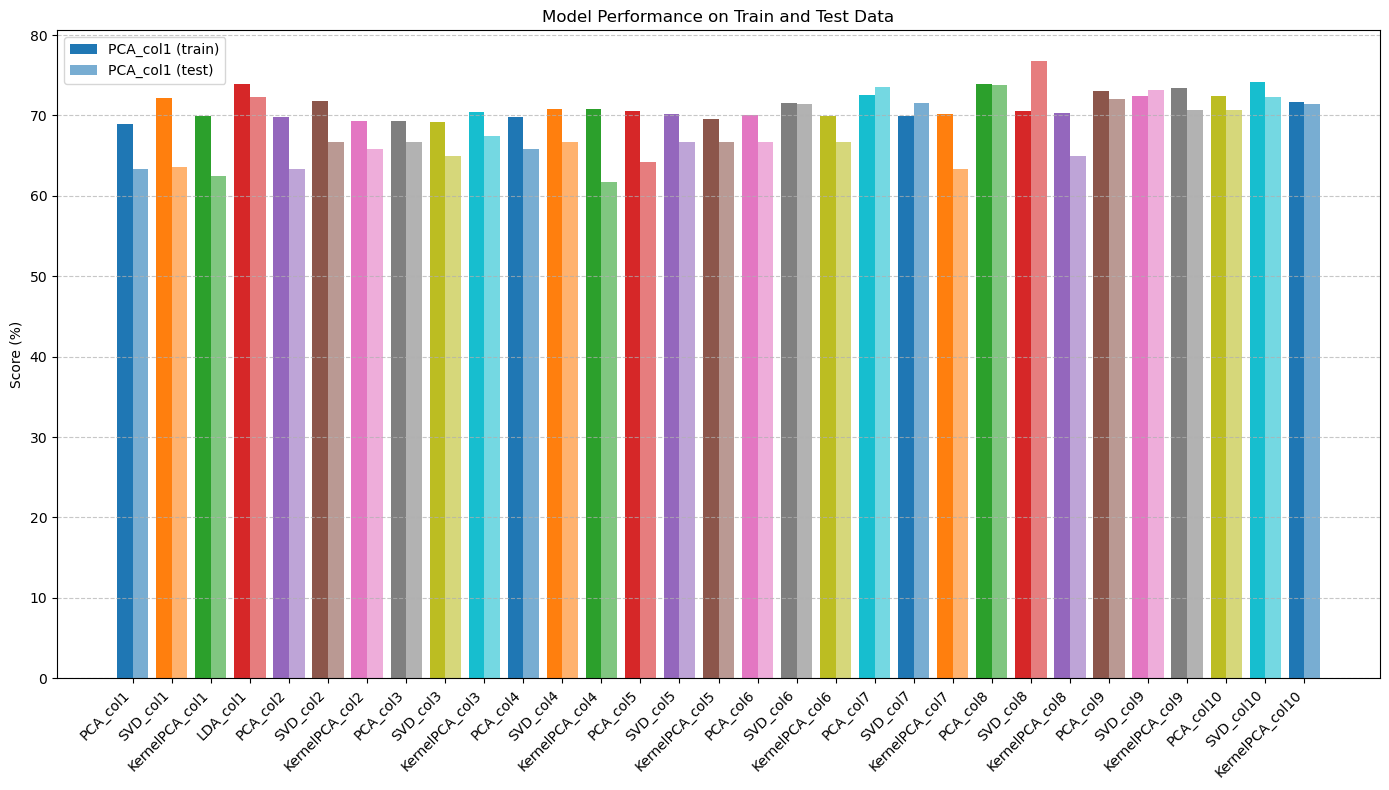

In [33]:
import matplotlib.pyplot as plt

models_and_components = list(results_train.keys())
train_scores = list(results_train.values())
test_scores = [results_test[model] for model in models_and_components]

# Extract model names and component values
x_labels = models_and_components
x_ticks = range(len(x_labels))

# Plot settings
bar_width = 0.4
colors = plt.cm.tab10.colors  # Use a colormap for consistent colors

# Create the bar plot
plt.figure(figsize=(14, 8))
for i, (train_score, test_score) in enumerate(zip(train_scores, test_scores)):
    color = colors[i % len(colors)]
    plt.bar(x_ticks[i] - bar_width / 2, train_score, bar_width, color=color, label=f"{x_labels[i]} (train)" if i == 0 else "")
    plt.bar(x_ticks[i] + bar_width / 2, test_score, bar_width, color=color, alpha=0.6, label=f"{x_labels[i]} (test)" if i == 0 else "")

# Customize plot
plt.xticks(ticks=x_ticks, labels=x_labels, rotation=45, ha="right")
plt.ylabel("Score (%)")
plt.title("Model Performance on Train and Test Data")
plt.legend(loc="best")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


## Create losses of the default dimension reduction models, based on different n_components, apply reduction only on continuous columns

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import Isomap
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
import numpy as np
import pandas as pd 

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Initialize results
results_train = {}
results_test = {}

# Dimensionality reduction and evaluation
for c in range(1, X_train_continuous.shape[1] - 1):
    models = {
        "PCA": PCA(n_components=c),
        "SVD": TruncatedSVD(n_components=c),
        "KernelPCA": KernelPCA(n_components=c, kernel="rbf"),
        "LDA": LinearDiscriminantAnalysis(n_components=c),
    }

    for name, model in models.items():
        # Skip invalid LDA configurations
        if name == "LDA" and c >= len(np.unique(y_train)):
            continue
        
        # Transform training data
        if name == "LDA":
            X_train_transformed = model.fit_transform(X_train_continuous, y_train)
        else:
            X_train_transformed = model.fit_transform(X_train_continuous)

        # Convert to DataFrame for concatenation
        X_train_transformed = pd.DataFrame(
            X_train_transformed,
            columns=[f"component_{i}" for i in range(X_train_transformed.shape[1])],
            index=X_train.index  
        )
        
        # Concatenate with encoded features
        X_train_combined = pd.concat([X_train_transformed, X_train_encoded], axis=1)
       
        # Train CatBoost model
        CatB = CatBoostClassifier(
            learning_rate=0.8, iterations=10, depth=6, min_data_in_leaf=1,
            subsample=0.8, colsample_bylevel=1.0, l2_leaf_reg=10,
            random_state=0, verbose=0
        )

        # Cross-validation
        scores = cross_val_score(CatB, X_train_combined, y_train, cv=kf, scoring='f1')
        results_train[name + "_col" + str(c)] = scores.mean() * 100

        # Train on full data and evaluate on test
        CatB.fit(X_train_combined, y_train)

        # Transform test data
        if name == "LDA":
            X_test_transformed = model.transform(X_test_continuous)
        else:
            X_test_transformed = model.transform(X_test_continuous)

        # Convert to DataFrame and concatenate with encoded test data
        X_test_transformed_df = pd.DataFrame(
            X_test_transformed,
            columns=[f"component_{i}" for i in range(X_test_transformed.shape[1])],
            index=X_test.index
        )
        X_test_combined = pd.concat([X_test_transformed_df, X_test_encoded], axis=1)

        # Predict on test data
        y_pred_test = CatB.predict(X_test_combined)
        results_test[name + "_col" + str(c)] = f1_score(y_test, y_pred_test) * 100


### Visualise result

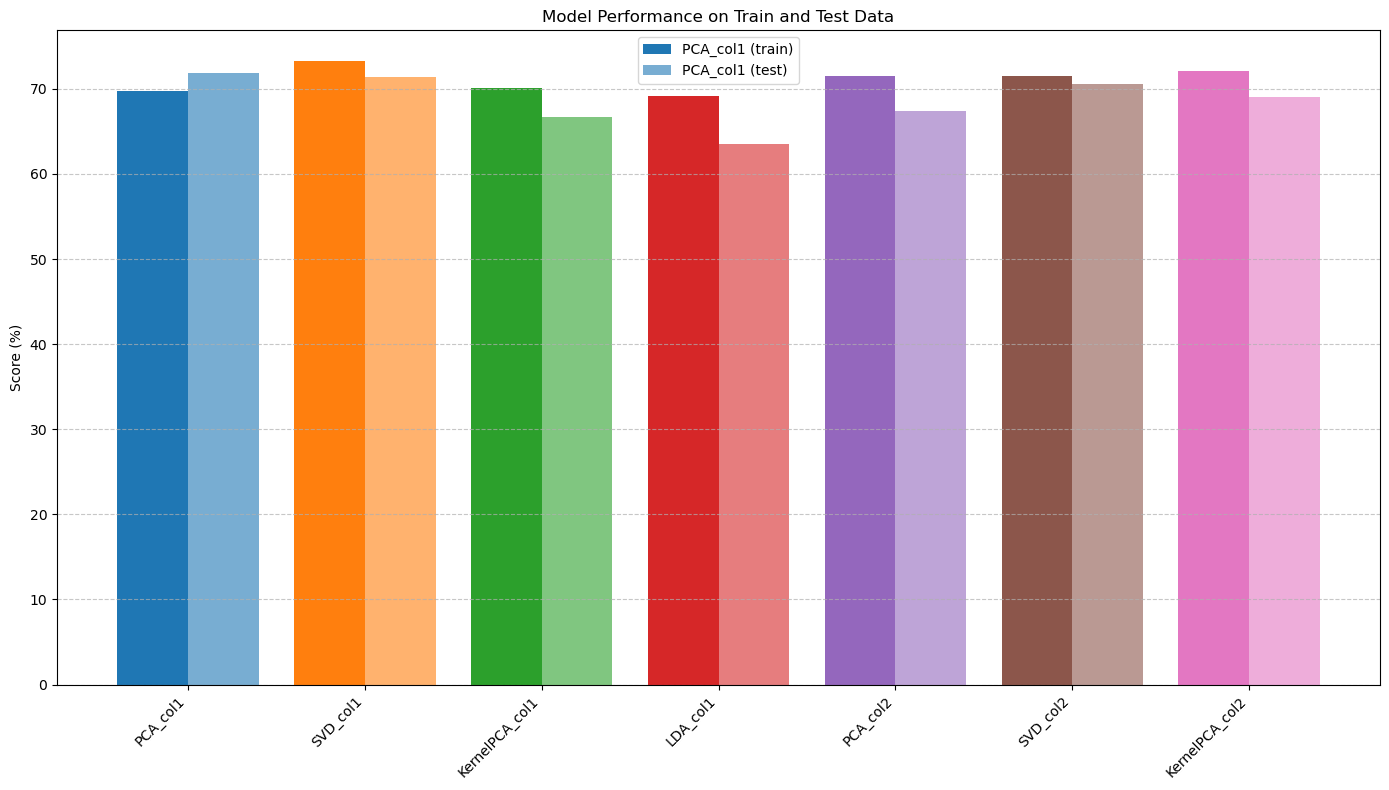

In [35]:
import matplotlib.pyplot as plt

models_and_components = list(results_train.keys())
train_scores = list(results_train.values())
test_scores = [results_test[model] for model in models_and_components]

# Extract model names and component values
x_labels = models_and_components
x_ticks = range(len(x_labels))

# Plot settings
bar_width = 0.4
colors = plt.cm.tab10.colors  # Use a colormap for consistent colors

# Create the bar plot
plt.figure(figsize=(14, 8))
for i, (train_score, test_score) in enumerate(zip(train_scores, test_scores)):
    color = colors[i % len(colors)]
    plt.bar(x_ticks[i] - bar_width / 2, train_score, bar_width, color=color, label=f"{x_labels[i]} (train)" if i == 0 else "")
    plt.bar(x_ticks[i] + bar_width / 2, test_score, bar_width, color=color, alpha=0.6, label=f"{x_labels[i]} (test)" if i == 0 else "")

# Customize plot
plt.xticks(ticks=x_ticks, labels=x_labels, rotation=45, ha="right")
plt.ylabel("Score (%)")
plt.title("Model Performance on Train and Test Data")
plt.legend(loc="best")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

### Don't find any improvement